# Tracking traffic on the Burke Gilman trail
This notebook will walk you through the process of exploring traffic patterns on the Burke Gilman trail, and asking and answering specific research questions using that data. The data we're using today comes from [data.seattle.gov](https://data.seattle.gov/) which is an online portal where the city of Seattle hosts publicly-available datasets. 

The exercises below will use the [Burke Gilman trail north of NE 70th St Bicycle and Pedestrian Counter](https://data.seattle.gov/Transportation/Burke-Gilman-Trail-north-of-NE-70th-St-Bicycle-and/2z5v-ecg8) dataset, which collects north and south traffic by bicyclists and pedestrians on a high-traffic portion of the Burke Gilman trail. 

# Gathering the data
Our first step here is to gather a sample of the data to work with. The full dataset is 53,000 rows, but we can use an API query to specify what time range we want to look at, so that we don't need to download the entire dataset. For now, we'll grab one year's worth of data—2019. 

If you want more practice with the Seattle Open Data API, you can use the notebook ``SODA_API_demo.ipynb``. 

In [1]:
#download the requests library, a bundle of code that is useful for sending and retrieving data over the internet
import requests

In [2]:
#the URL we're retrieving the data from. Copy/paste it into your browser to view it!
api_endpoint = "https://data.seattle.gov/resource/2z5v-ecg8.json?"

#the parameters we're passing to the API, to specify what subset of data we want.
api_parameters = "$limit=50000&$where=date > '2019-01-01T00:00:00' AND date < '2020-01-01T00:00:00'"

Now we will combine these two strings into a single long URL, which is our API request. It ends up looking like this (run the cell below).

In [3]:
print(api_endpoint + api_parameters)

https://data.seattle.gov/resource/2z5v-ecg8.json?$limit=50000&$where=date > '2019-01-01T00:00:00' AND date < '2020-01-01T00:00:00'


Copy and paste that full string into your browser to get a sneak peak at the data we'll be working with!

In [4]:
#request the data from the API
api_request = requests.get(api_endpoint + api_parameters)

#turn this data into a list of dictionaries, so that we can work with it in Python
raw_data = api_request.json()

Now we have the data, let's see what it looks like...

In [5]:
#how many rows are in our dataset?
print(len(raw_data))

8759


In [6]:
# See the first 5 data entries
print(raw_data[:5])

# Uncomment this if you want to see the full raw data.
# print(raw_data) 

[{'date': '2019-01-01T01:00:00.000', 'bgt_north_of_ne_70th_total': '2', 'ped_south': '1', 'ped_north': '0', 'bike_north': '1', 'bike_south': '0'}, {'date': '2019-01-01T02:00:00.000', 'bgt_north_of_ne_70th_total': '1', 'ped_south': '0', 'ped_north': '0', 'bike_north': '0', 'bike_south': '1'}, {'date': '2019-01-01T03:00:00.000', 'bgt_north_of_ne_70th_total': '0', 'ped_south': '0', 'ped_north': '0', 'bike_north': '0', 'bike_south': '0'}, {'date': '2019-01-01T04:00:00.000', 'bgt_north_of_ne_70th_total': '1', 'ped_south': '0', 'ped_north': '0', 'bike_north': '1', 'bike_south': '0'}, {'date': '2019-01-01T05:00:00.000', 'bgt_north_of_ne_70th_total': '1', 'ped_south': '0', 'ped_north': '0', 'bike_north': '1', 'bike_south': '0'}]


That's kind of hard to read, isn't it? Fortunately, there's another useful Python library called "pretty print" (``pprint``), that we can use to make it easier to read this data structure.

In [7]:
#import the pretty print library
from pprint import pprint 

You use ``pprint`` the same way you use ``print``

In [8]:
# See the first 5 data entries
pprint(raw_data[:5])

# Uncomment this if you want to see the full raw data.
# pprint(raw_data) 

[{'bgt_north_of_ne_70th_total': '2',
  'bike_north': '1',
  'bike_south': '0',
  'date': '2019-01-01T01:00:00.000',
  'ped_north': '0',
  'ped_south': '1'},
 {'bgt_north_of_ne_70th_total': '1',
  'bike_north': '0',
  'bike_south': '1',
  'date': '2019-01-01T02:00:00.000',
  'ped_north': '0',
  'ped_south': '0'},
 {'bgt_north_of_ne_70th_total': '0',
  'bike_north': '0',
  'bike_south': '0',
  'date': '2019-01-01T03:00:00.000',
  'ped_north': '0',
  'ped_south': '0'},
 {'bgt_north_of_ne_70th_total': '1',
  'bike_north': '1',
  'bike_south': '0',
  'date': '2019-01-01T04:00:00.000',
  'ped_north': '0',
  'ped_south': '0'},
 {'bgt_north_of_ne_70th_total': '1',
  'bike_north': '1',
  'bike_south': '0',
  'date': '2019-01-01T05:00:00.000',
  'ped_north': '0',
  'ped_south': '0'}]


Now that we have our data sample and we know how the data is organized (a list of dictionaries, with one dictionary for each hour of traffic), we can start asking research questions about the data.

## Question #1: how many people used the Burke Gilman during commute hours in 2019?

City planners often need to know the traffic volumes on particular roads and trails, so that they can prioritize maintenance and improvements. Anyone who's been on the Burke Gilman on a weekday at 5pm knows that it's a busy thoroughfare, but how busy is it?

For our first step, we need to decide what we mean by commute hours. Let's say between 6am and 9:59am is the "morning" communte, and 3pm-6:59pm is the "evening commute".

We'll store these values in two lists, so that as we loop through each hour in the dataset later we can check whether the traffic during that hour falls within the morning or evening commute. 

In [9]:
morning_commute_hours = ['06:00:00','07:00:00', '08:00:00', '09:00:00']
evening_commute_hours = ['15:00:00','16:00:00', '17:00:00', '18:00:00']

Now we need some place to store the morning/evening commute counts, as we loop through the dataset. We'll create a dictionary with keys for 'morning' and 'evening' for this purpose. The values for each of these will start at 0, and increase as we loop through the dataset and add the traffic we see.

In [10]:
#create an empty dictionary to hold our counts
commuters = {'morning':0, 'evening':0}

Now we can loop through our ``raw data`` list and examine each dictionary in that list. If the time of day in that dictionary matches one of the times we've listed in our morning and evening commute hour lists we made above, then we take the value of ``bgt_north_of_ne_70th_total`` for that dictionary and add it to one of the totals in ``commuters``. If it doesn't match, we move on to the next one and do the same thing.

In [11]:
for hour_count in raw_data:

    traffic_hour = hour_count['date'][11:19] #get the timestamp
    
    if traffic_hour in morning_commute_hours: #if it's in the morning, add the count to our morning total
        commuters['morning'] = commuters['morning'] + int(hour_count['bgt_north_of_ne_70th_total'])
    
    elif traffic_hour in evening_commute_hours: #if it's in the evening, add the count to our evening total
        commuters['evening'] = commuters['evening'] + int(hour_count['bgt_north_of_ne_70th_total'])
    
    else:
        pass #we don't care who's on the BGT during non-commute hours, so we ignore it and move on

### Understanding the loop we just made

#### interlude 1: data types
If you scroll up to our pprinted dataset above, you'll see that the numeric values for ``bgt_north_of_ne_70th_total`` (the hourly traffic counts) have '' around them. This means they are being stored as strings.


In [12]:
#we can ask Python to tell us what type of value this is using 'type'
print(type(raw_data[0]['bgt_north_of_ne_70th_total']))

<class 'str'>


If we want to add these numeric values together, we will need to turn them into integers. That's what's happening when you see ``int(hour_count['bgt_north_of_ne_70th_total'])`` in the loop above.

In [13]:
#converting the string to an integer
str_to_int = int(raw_data[0]['bgt_north_of_ne_70th_total'])

print(type(str_to_int))

<class 'int'>


#### interlude 2: slicing
The date and time for each item in the list is stored in a single string, like ``'2019-01-01T06:00:00.000'`` Right now, we are only interested in the time of day, which is in the middle—between "T" (position 10) and "." (position 19), so we slice the beginning and the end of the string off before we compare the value with our commute hour lists.

In [14]:
print(raw_data[0]['date'])

2019-01-01T01:00:00.000


In [15]:
print(raw_data[0]['date'][:11]) #slice the string to just get the stuff before the time

2019-01-01T


In [16]:
print(raw_data[0]['date'][19:]) #slice the string to just get the stuff after the time

.000


In [17]:
print(raw_data[0]['date'][11:19]) #slice the string to just get the time

01:00:00


### Getting the answer to Q1
Now if our loop above worked, we'll know how many people used the Burke Gilman during commute hours in 2019 (at 70th street, at least)!

In [18]:
pprint(commuters)

{'evening': 168241, 'morning': 114366}


In [19]:
#we can make these values into a human readable sentence, if we convert the ints back into strings
print("There were " 
    + str(commuters['morning']) 
    + " morning commuters and " 
    + str(commuters['evening']) 
    + " on the Burke Gilman at 70th Street in 2019!"
     )
      
      

There were 114366 morning commuters and 168241 on the Burke Gilman at 70th Street in 2019!


## Question 2: what were the busiest hours on the Burke Gilman in 2019?
Let's say you want to know when the Burke Gilman is least likely to be congested, so you can plan your trip. How would you find this out? 

To do this, we need to start with a list of all of the hours of the day. We could do this manually by creating a list like we did with the morning and evening commute hours lists above, but since there are 24 hours in a day that would take a long time to type out manually! Is there a quicker way?

In [20]:
#create an empty dictionary, that we will fill with hours
traffic_by_hour = {}

In [21]:
#loop through the dataset again...
for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19] #grab the hour value from the item
    
    #if haven't seen this hour yet during the loop...
    if traffic_hour not in traffic_by_hour.keys():
        
        # ...create an item for it in our dictionary that we can use later to track our cumulative hourly counts
        traffic_by_hour[traffic_hour] = 0 #e.g {'01:00:00' : 0}
   
    else:
        pass
        #if we've already seen this hour and stored it in our dictionary, ignore it and move on to the next one

In [22]:
#how many hours in our list?
len(traffic_by_hour)

24

In [23]:
#what does our list look like?
pprint(traffic_by_hour)

{'00:00:00': 0,
 '01:00:00': 0,
 '02:00:00': 0,
 '03:00:00': 0,
 '04:00:00': 0,
 '05:00:00': 0,
 '06:00:00': 0,
 '07:00:00': 0,
 '08:00:00': 0,
 '09:00:00': 0,
 '10:00:00': 0,
 '11:00:00': 0,
 '12:00:00': 0,
 '13:00:00': 0,
 '14:00:00': 0,
 '15:00:00': 0,
 '16:00:00': 0,
 '17:00:00': 0,
 '18:00:00': 0,
 '19:00:00': 0,
 '20:00:00': 0,
 '21:00:00': 0,
 '22:00:00': 0,
 '23:00:00': 0}


## Getting the answer to Q2
Awesome! Now that we have buckets ready to hold counts for each hour in the day, we can loop through the raw data again and start calculating the traffic counts for each hour.

In [24]:
for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19]

    traffic_by_hour[traffic_hour] =  traffic_by_hour[traffic_hour] + int(hour_data['bgt_north_of_ne_70th_total'])

    #you can also un-comment the following line and run it instead of the line directly above.
    #this is a slightly shorter way to do the same thing. Re-set traffic_by_hour to zero and try it!
#     traffic_by_hour[traffic_hour] += int(hour_data['bgt_north_of_ne_70th_total'])

In [25]:
pprint(traffic_by_hour)

{'00:00:00': 343,
 '01:00:00': 157,
 '02:00:00': 147,
 '03:00:00': 203,
 '04:00:00': 760,
 '05:00:00': 4304,
 '06:00:00': 15275,
 '07:00:00': 25894,
 '08:00:00': 37369,
 '09:00:00': 35828,
 '10:00:00': 36095,
 '11:00:00': 38024,
 '12:00:00': 37621,
 '13:00:00': 38328,
 '14:00:00': 39132,
 '15:00:00': 40675,
 '16:00:00': 46041,
 '17:00:00': 46997,
 '18:00:00': 34528,
 '19:00:00': 18987,
 '20:00:00': 9167,
 '21:00:00': 3789,
 '22:00:00': 1376,
 '23:00:00': 692}


It looks like the busiest hour is between 5 and 6pm!

#### interlude 3: plus-equals
Writing long lines of code like ``commuters['morning'] = commuters['morning'] + int(hour_count['bgt_north_of_ne_70th_total'])`` can be tedious, and it makes it more likely that you will make a typo that causes your code to crash. There's an easier way!

Instead of writing ``thing_one = thing_one + thing_two``, you can write ``thing_one += thing_two``. It does the same thing! 

You can try this out yourself by re-running cells 35-38 above, and then using the code ``traffic_by_hour[traffic_hour] += int(hour_data['bgt_north_of_ne_70th_total'])`` 

...instead of the line ``traffic_by_hour[traffic_hour] =  traffic_by_hour[traffic_hour] + int(hour_data['bgt_north_of_ne_70th_total'])``

### Going further with Question 3
- Challenge #1: How would you use Python to find the HOUR with the most traffic? This list is short, so we can probably easily identify the element with the most traffic just by looking at it. But what if it had 10k items in it? How would YOU find the hour with the most traffic?
- Challegen #2: How would you find the busiest DAY on the Burke Gilman in 2019? You should be able to answer this question with the same techniques you used to find the busiest hour!


## Question 3: What is the busiest hours for bikes vs pedestrians?
One cool thing about this dataset is that it doesn't just count by hour, it counts by what kind of traffic: bikes or pedestrians. Let's run the same set of commands as above, but this time we'll break things apart into bikes and peds.

In [26]:
#create an empty dictionary
traffic_by_hour_bp = {}

for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19]
    
    #if haven't seen this hour yet, create an item for it that we can use to track hourly counts later
    if traffic_hour not in traffic_by_hour_bp.keys():
        
        #this time, we create a dictionary-in-a-dictionary, to hold our bike and pedestrian counts separately
        traffic_by_hour_bp[traffic_hour] = {'bikes' : 0, 'pedestrians' : 0}
    
    else:
        pass
        #if we've already seen this hour and stored it in our dictionary, ignore it and move on

pprint(traffic_by_hour_bp)

{'00:00:00': {'bikes': 0, 'pedestrians': 0},
 '01:00:00': {'bikes': 0, 'pedestrians': 0},
 '02:00:00': {'bikes': 0, 'pedestrians': 0},
 '03:00:00': {'bikes': 0, 'pedestrians': 0},
 '04:00:00': {'bikes': 0, 'pedestrians': 0},
 '05:00:00': {'bikes': 0, 'pedestrians': 0},
 '06:00:00': {'bikes': 0, 'pedestrians': 0},
 '07:00:00': {'bikes': 0, 'pedestrians': 0},
 '08:00:00': {'bikes': 0, 'pedestrians': 0},
 '09:00:00': {'bikes': 0, 'pedestrians': 0},
 '10:00:00': {'bikes': 0, 'pedestrians': 0},
 '11:00:00': {'bikes': 0, 'pedestrians': 0},
 '12:00:00': {'bikes': 0, 'pedestrians': 0},
 '13:00:00': {'bikes': 0, 'pedestrians': 0},
 '14:00:00': {'bikes': 0, 'pedestrians': 0},
 '15:00:00': {'bikes': 0, 'pedestrians': 0},
 '16:00:00': {'bikes': 0, 'pedestrians': 0},
 '17:00:00': {'bikes': 0, 'pedestrians': 0},
 '18:00:00': {'bikes': 0, 'pedestrians': 0},
 '19:00:00': {'bikes': 0, 'pedestrians': 0},
 '20:00:00': {'bikes': 0, 'pedestrians': 0},
 '21:00:00': {'bikes': 0, 'pedestrians': 0},
 '22:00:00

## Getting the answer to Q3
Now that we have the right buckets for every value we want to capture, we're ready to get counts for bikes and peds separately.

In [27]:
for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19]
    
    #note that we're using the 'plus-equals' technique now, which means we have to write less code
    traffic_by_hour_bp[traffic_hour]['bikes'] += int(hour_data['bike_north']) #add northbound bike counts
    traffic_by_hour_bp[traffic_hour]['bikes'] += int(hour_data['bike_south']) #add southbound bike counts
    
    traffic_by_hour_bp[traffic_hour]['pedestrians'] += int(hour_data['ped_north']) #add northbound ped counts
    traffic_by_hour_bp[traffic_hour]['pedestrians'] += int(hour_data['ped_south']) #add sounthbound ped counts

In [28]:
pprint(traffic_by_hour_bp)

{'00:00:00': {'bikes': 245, 'pedestrians': 98},
 '01:00:00': {'bikes': 99, 'pedestrians': 58},
 '02:00:00': {'bikes': 103, 'pedestrians': 44},
 '03:00:00': {'bikes': 179, 'pedestrians': 24},
 '04:00:00': {'bikes': 640, 'pedestrians': 120},
 '05:00:00': {'bikes': 3375, 'pedestrians': 929},
 '06:00:00': {'bikes': 11413, 'pedestrians': 3862},
 '07:00:00': {'bikes': 19422, 'pedestrians': 6472},
 '08:00:00': {'bikes': 24499, 'pedestrians': 12870},
 '09:00:00': {'bikes': 21565, 'pedestrians': 14263},
 '10:00:00': {'bikes': 22624, 'pedestrians': 13471},
 '11:00:00': {'bikes': 26064, 'pedestrians': 11960},
 '12:00:00': {'bikes': 26678, 'pedestrians': 10943},
 '13:00:00': {'bikes': 28166, 'pedestrians': 10162},
 '14:00:00': {'bikes': 29157, 'pedestrians': 9975},
 '15:00:00': {'bikes': 30443, 'pedestrians': 10232},
 '16:00:00': {'bikes': 34648, 'pedestrians': 11393},
 '17:00:00': {'bikes': 37291, 'pedestrians': 9706},
 '18:00:00': {'bikes': 26761, 'pedestrians': 7767},
 '19:00:00': {'bikes': 141

Now that there is more data in the notebook, it's a bit harder to figure out the busiest hour for bikes and pedestrians separately, just by looking. So let's use a quick loop to find this.

In [29]:
top_bike = ['some hour', 0]
top_ped = ['some hour', 0]

for hour, traffic in traffic_by_hour_bp.items():

    if traffic['bikes'] > top_bike[1]:
        top_bike[0] = hour
        top_bike[1] = traffic['bikes']
    else:
        pass
    
    if traffic['pedestrians'] > top_ped[1]:
        top_ped[0] = hour
        top_ped[1] = traffic['pedestrians']
    else:
        pass
    
print("The hour with the most bike traffic is " + top_bike[0] + ", with " + str(top_bike[1]) + " bikes!")
print("The hour with the most pedestrian traffic is " + top_ped[0] + ", with " + str(top_ped[1]) + " pedestrians!")

    

The hour with the most bike traffic is 17:00:00, with 37291 bikes!
The hour with the most pedestrian traffic is 09:00:00, with 14263 pedestrians!


# Going further Question #1
- Were there more bikes or pedestrians using the Burke Gilman trail in 2019?
Use the block below and try to answer this question. 

In [30]:
# Code for Question 1 goes here.

## Question 4: What is the busiest hour for bikes vs. peds AND northbound vs. southbound?

If we want, we can break our data down by bikes vs. peds AND northbound vs. southbound. This is useful because it helps us understand how many people are using the Burke Gilman trail for daily commuting, not just for pleasure trips. 

Splitting bike and pedestrian traffic by northboud/southbound is actually almost as easy as lumping them together. We just make our dictionary-in-a-dictionary a little more complex.


In [31]:
#create a new empty dictionary
traffic_by_hour_bpd = {}

for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19]
    
    if traffic_hour not in traffic_by_hour_bpd.keys():

        traffic_by_hour_bpd[traffic_hour] = {'bikes north' : 0, 'pedestrians north' : 0, 
                                            'bikes south' : 0, 'pedestrians south' : 0}  
    else:
        pass

pprint(traffic_by_hour_bpd)

{'00:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '01:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '02:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '03:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '04:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '05:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '06:00:00': {'bikes north': 0,
              'bikes south': 0,
              'pedestrians north': 0,
              'pedestrians south': 0},
 '07:00:00': 

And now instead of adding bike_north + bike_south etc together, we store each of those counts in their own key/value bucket.

In [32]:
for hour_data in raw_data:
    
    traffic_hour = hour_data['date'][11:19]
    
    traffic_by_hour_bpd[traffic_hour]['bikes north'] += int(hour_data['bike_north']) #store count in bike_north
    traffic_by_hour_bpd[traffic_hour]['bikes south'] += int(hour_data['bike_south']) #store count in bike_south
    
    traffic_by_hour_bpd[traffic_hour]['pedestrians north'] += int(hour_data['ped_north'])
    traffic_by_hour_bpd[traffic_hour]['pedestrians south'] += int(hour_data['ped_south'])

pprint(traffic_by_hour_bpd)

{'00:00:00': {'bikes north': 57,
              'bikes south': 188,
              'pedestrians north': 50,
              'pedestrians south': 48},
 '01:00:00': {'bikes north': 30,
              'bikes south': 69,
              'pedestrians north': 31,
              'pedestrians south': 27},
 '02:00:00': {'bikes north': 18,
              'bikes south': 85,
              'pedestrians north': 21,
              'pedestrians south': 23},
 '03:00:00': {'bikes north': 77,
              'bikes south': 102,
              'pedestrians north': 11,
              'pedestrians south': 13},
 '04:00:00': {'bikes north': 474,
              'bikes south': 166,
              'pedestrians north': 55,
              'pedestrians south': 65},
 '05:00:00': {'bikes north': 2399,
              'bikes south': 976,
              'pedestrians north': 416,
              'pedestrians south': 513},
 '06:00:00': {'bikes north': 7825,
              'bikes south': 3588,
              'pedestrians north': 2023,
          

### Answering question 4
I will leave it up to you to find the answer to any of these questions (you already know how to do it!)
- What is the busiest hour for northbound bike traffic? For southbound bike traffic?
- What is the busiest hour for northbound pedestrian traffic? For southbound pedestrian traffic?

If you don't feel like writing code to answer these questions right now, that's okay. Below, I will show you how to export this data in a format that can be used to easily create timeseries graphs in a spreadsheet. It will be much easier to answer these questions with a graph than by looking at rows of numbers!

## Exporting the bike/ped north/south dataset for visualization

Now we have some nice rich data that we can graph in a spreadsheet program like Google Sheets or Microsoft Excel. 

But to do that, we will need to convert the data to CSV format and export it into a file. We ideally want a format that has a row for each hour, and columns like
``hour_of_day | bikes_north | bikes_south | pedestrians_north | pedestrians_south``
 
The best way to do this is to convert our data from a nested dictionary to a nested list (a list-of-lists!), where each sub-list (which will be a row in our CSV file), contains the values in a consistent order, like:

``[hour_of_day, bike_north, bike_south, ped_north, ped_south]``

In [44]:
#create a new empty 'master list'
traffic_by_hour_mode_direction = []

#for each hour in our traffic-by-hour-mode-direction dictionary...
for hour, counts in traffic_by_hour_bpd.items():
    
    #...create a new sub-list that will store the hour, bike, and pedestrian data in a consistent order
    list_element = [] #new empty sub-list
    list_element.append(hour) #add the hour in, e.g. ['06:00:00']
    list_element.append(counts['bikes north']) #append bike north count, e.g. ['06:00:00', 484]
    list_element.append(counts['bikes south']) #append bike south count, e.g. ['06:00:00', 484, 82]
    list_element.append(counts['pedestrians north']) # etc...
    list_element.append(counts['pedestrians south']) # etc... 
    
    traffic_by_hour_mode_direction.append(list_element) #add this list to the end of our growing master list
    
    

In [45]:
pprint(traffic_by_hour_mode_direction)

[['01:00:00', 30, 69, 31, 27],
 ['02:00:00', 18, 85, 21, 23],
 ['03:00:00', 77, 102, 11, 13],
 ['04:00:00', 474, 166, 55, 65],
 ['05:00:00', 2399, 976, 416, 513],
 ['06:00:00', 7825, 3588, 2023, 1839],
 ['07:00:00', 13207, 6215, 3425, 3047],
 ['08:00:00', 16379, 8120, 6236, 6634],
 ['09:00:00', 11410, 10155, 7637, 6626],
 ['10:00:00', 10517, 12107, 6805, 6666],
 ['11:00:00', 12097, 13967, 5997, 5963],
 ['12:00:00', 12782, 13896, 5671, 5272],
 ['13:00:00', 12944, 15222, 5355, 4807],
 ['14:00:00', 13383, 15774, 5067, 4908],
 ['15:00:00', 13851, 16592, 5143, 5089],
 ['16:00:00', 13858, 20790, 5680, 5713],
 ['17:00:00', 12569, 24722, 4765, 4941],
 ['18:00:00', 9285, 17476, 3841, 3926],
 ['19:00:00', 5986, 8115, 2562, 2324],
 ['20:00:00', 3024, 3350, 1525, 1268],
 ['21:00:00', 1360, 1336, 628, 465],
 ['22:00:00', 405, 564, 200, 207],
 ['23:00:00', 154, 326, 109, 103],
 ['00:00:00', 57, 188, 50, 48]]


This worked! BUT something odd happened. Can you see it? For some reason, our '00:00:00' hour got moved to the end of the list. 

This happened because Python dictionaries do not reliably preserve the order of items! So even though the data looked like it was in the right order when we had it in the dictionary, when we created our new master list from ``traffic_by_hour_bpd`` it ended up a little out of order. 

Fortunately, unlike dictionaries, lists-of-lists are easy to sort! Especially if you want to sort by the first item in each sub-list, which we do!

In [46]:
#sort the list in 'alphabetical order' by the first sub-item, which is the hour stamp
traffic_by_hour_mode_direction.sort() 

Now that we have our data in a list, it's easy to export to a CSV file!

In [52]:
import csv

In [53]:
with open('bg_traffic_bike_ped_2019.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    #write a header row
    writer.writerow(('hour of the day', 
                     'northbound bikes', 
                     'southbound bikes', 
                     'northbound pedestrians',
                     'southbound pedestrians'))
    
    for i in traffic_by_hour_mode_direction:
        writer.writerow((i[0], i[1], i[2], i[3], i[4]))

In [56]:
import pandas as pd
df_plot = pd.read_csv('bg_traffic_bike_ped_2019.csv')
df_plot

,hour of the day,northbound bikes,southbound bikes,northbound pedestrians,southbound pedestrians
0,00:00:00,57,188,50,48
1,01:00:00,30,69,31,27
2,02:00:00,18,85,21,23
3,03:00:00,77,102,11,13
4,04:00:00,474,166,55,65
5,05:00:00,2399,976,416,513
6,06:00:00,7825,3588,2023,1839
7,07:00:00,13207,6215,3425,3047
8,08:00:00,16379,8120,6236,6634
9,09:00:00,11410,10155,7637,6626


In [58]:
df_plot.iloc[:, 1:]

,northbound bikes,southbound bikes,northbound pedestrians,southbound pedestrians
0,57,188,50,48
1,30,69,31,27
2,18,85,21,23
3,77,102,11,13
4,474,166,55,65
5,2399,976,416,513
6,7825,3588,2023,1839
7,13207,6215,3425,3047
8,16379,8120,6236,6634
9,11410,10155,7637,6626


## Human attempt

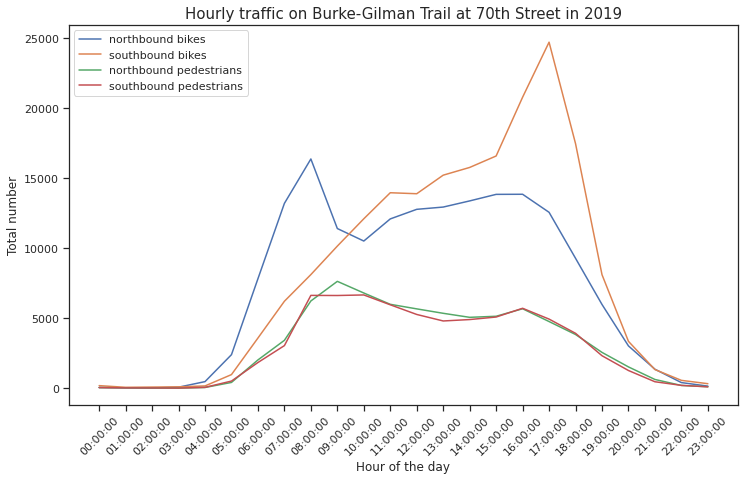

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
df_plot = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Create plot
plt.subplots(figsize=(12, 7))
plt.plot(df_plot['hour of the day'], df_plot.iloc[:, 1:], label = df_plot.columns[1:])

# Customize plot
plt.title("Hourly traffic on Burke-Gilman Trail at 70th Street in 2019", size = 15)
plt.xlabel("Hour of the day", size = 12)
plt.ylabel("Total number", size = 12)
plt.xticks(rotation=45)
plt.legend()

# Display plot
plt.show()

## ChatGPT's attempt
#### Prompt: 
#### I'm creating a visualization using the Burke Gilman Trail north of NE 70th St Bicycle and Pedestrian Counter dataset. The dataset has 5 columns:
#### 1. "hour of the day": The date and hour of day object(s) are detected by the sensor.
#### 2. "southbound pedestrians": The total number of pedestrians traveling south in one hour as recorded by the sensor.
#### 3. "northbound pedestrians": The total number of pedestrians traveling north in one hour as recorded by the sensor.
#### 4. "northbound bikes": The total number of  bicyclists traveling north in one hour as recorded by the sensor.
#### 5. "southbound bikes": The total number of  bicyclists traveling south in one hour as recorded by the sensor.

#### Can you generate the code for a cool visualization?

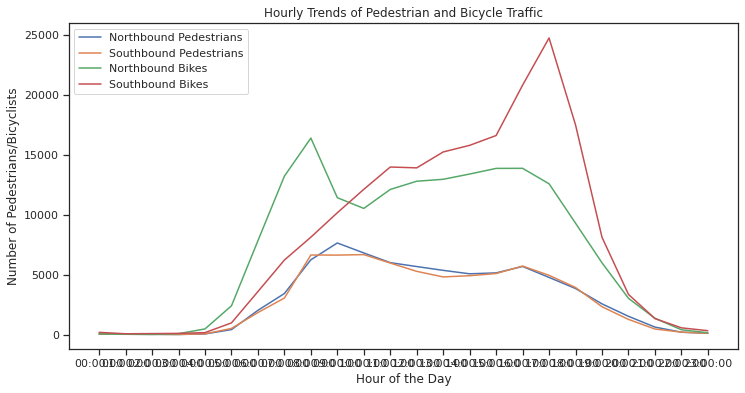

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data
ax.plot(df['hour of the day'], df['northbound pedestrians'], label='Northbound Pedestrians')
ax.plot(df['hour of the day'], df['southbound pedestrians'], label='Southbound Pedestrians')
ax.plot(df['hour of the day'], df['northbound bikes'], label='Northbound Bikes')
ax.plot(df['hour of the day'], df['southbound bikes'], label='Southbound Bikes')

# Customize plot
ax.set_title('Hourly Trends of Pedestrian and Bicycle Traffic')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Pedestrians/Bicyclists')
ax.legend()

# Display plot
plt.show()


#### Prompt: Rotate x axis labels by 45 degrees

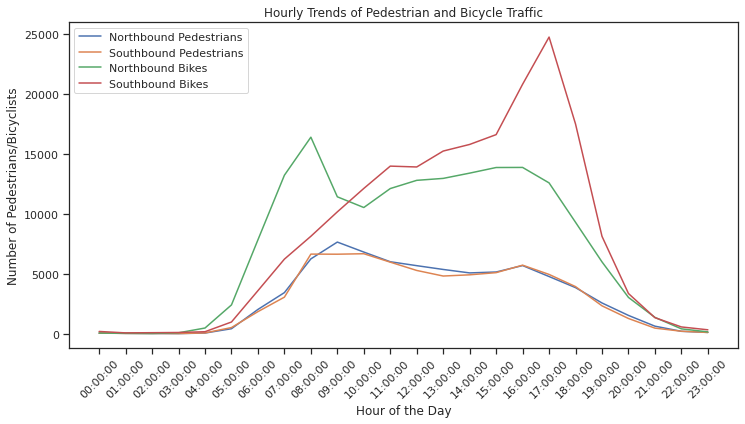

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data
ax.plot(df['hour of the day'], df['northbound pedestrians'], label='Northbound Pedestrians')
ax.plot(df['hour of the day'], df['southbound pedestrians'], label='Southbound Pedestrians')
ax.plot(df['hour of the day'], df['northbound bikes'], label='Northbound Bikes')
ax.plot(df['hour of the day'], df['southbound bikes'], label='Southbound Bikes')

# Customize plot
ax.set_title('Hourly Trends of Pedestrian and Bicycle Traffic')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Pedestrians/Bicyclists')
ax.legend()
plt.xticks(rotation=45)

# Display plot
plt.show()


#### Prompt: Make the plot prettier

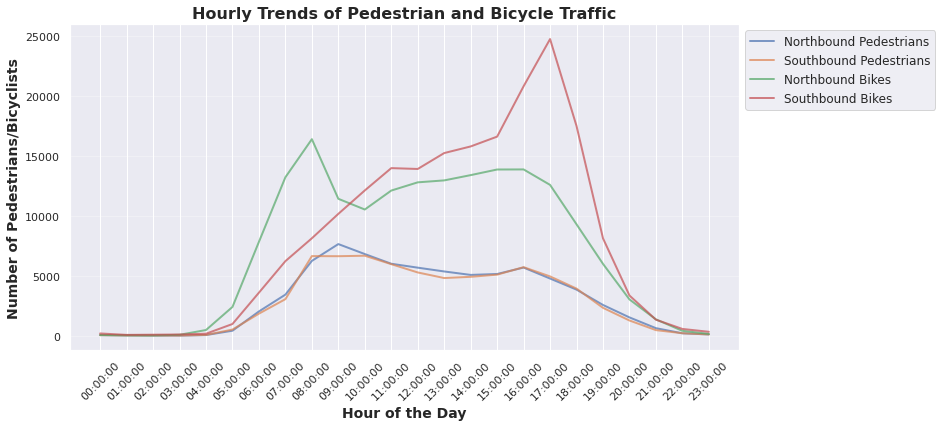

In [144]:
# Set default seaborn style
sns.set()

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data
ax.plot(df['hour of the day'], df['northbound pedestrians'], label='Northbound Pedestrians', linewidth=2, alpha=0.7)
ax.plot(df['hour of the day'], df['southbound pedestrians'], label='Southbound Pedestrians', linewidth=2, alpha=0.7)
ax.plot(df['hour of the day'], df['northbound bikes'], label='Northbound Bikes', linewidth=2, alpha=0.7)
ax.plot(df['hour of the day'], df['southbound bikes'], label='Southbound Bikes', linewidth=2, alpha=0.7)

# Customize plot
ax.set_title('Hourly Trends of Pedestrian and Bicycle Traffic', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour of the Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Pedestrians/Bicyclists', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Display plot
plt.show()


#### Prompt: Create another version of fancier plot that you would see in coolvisualizations.com

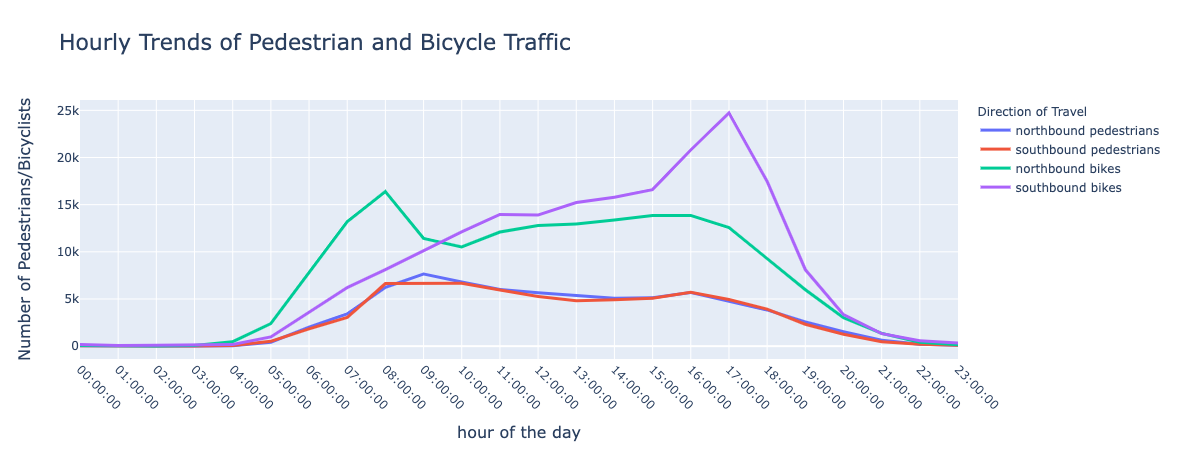

In [173]:
import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Create figure with plotly express
fig = px.line(df, x='hour of the day', y=['northbound pedestrians', 'southbound pedestrians', 'northbound bikes', 'southbound bikes'],
              labels={'value': 'Number of Pedestrians/Bicyclists', 'variable': 'Direction of Travel'},
              title='Hourly Trends of Pedestrian and Bicycle Traffic')

# Customize plot
fig.update_layout(title_font=dict(size=22), xaxis_title_font=dict(size=16), yaxis_title_font=dict(size=16))
fig.update_traces(line=dict(width=3), mode='lines')
fig.update_xaxes(tickangle=45, dtick=1)

# Display plot
fig.show()

#### Prompt: Create another version of a pretty plot that you would see in a New York Times article

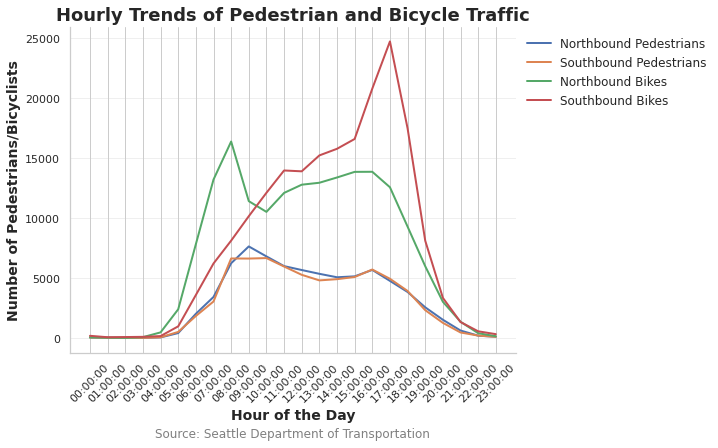

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Set default seaborn style
sns.set_style('whitegrid')

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot data
ax.plot(df['hour of the day'], df['northbound pedestrians'], label='Northbound Pedestrians', linewidth=2)
ax.plot(df['hour of the day'], df['southbound pedestrians'], label='Southbound Pedestrians', linewidth=2)
ax.plot(df['hour of the day'], df['northbound bikes'], label='Northbound Bikes', linewidth=2)
ax.plot(df['hour of the day'], df['southbound bikes'], label='Southbound Bikes', linewidth=2)

# Customize plot
ax.set_title('Hourly Trends of Pedestrian and Bicycle Traffic', fontsize=18, fontweight='bold')
ax.set_xlabel('Hour of the Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Pedestrians/Bicyclists', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Add source line
# plt.annotate('Source: Seattle Department of Transportation', (0.02, 0.01), xycoords='figure fraction', fontsize=8, color='gray')

# Add source line
source_text = 'Source: Seattle Department of Transportation'
ax.text(0.5, -0.25, source_text, transform=ax.transAxes, fontsize=12, ha='center', va='center', color='gray')

# Display plot
plt.show()


#### Prompt: Create different types of visualization

Bar plot to compare the total number of pedestrians and bicyclists for each direction of travel:


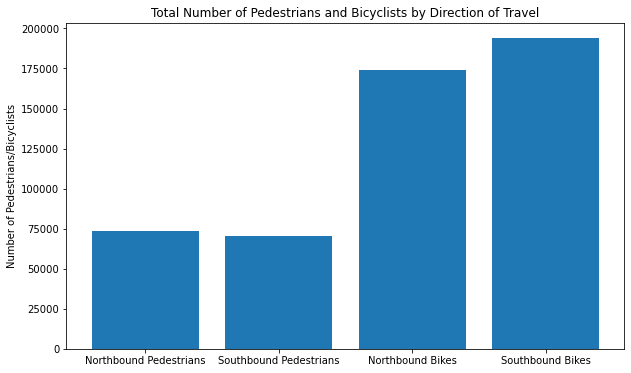

In [102]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate total number of pedestrians and bicyclists for each direction of travel
northbound_pedestrians = df['northbound pedestrians'].sum()
southbound_pedestrians = df['southbound pedestrians'].sum()
northbound_bikes = df['northbound bikes'].sum()
southbound_bikes = df['southbound bikes'].sum()

# Create bar plot
ax.bar(['Northbound Pedestrians', 'Southbound Pedestrians', 'Northbound Bikes', 'Southbound Bikes'], 
       [northbound_pedestrians, southbound_pedestrians, northbound_bikes, southbound_bikes])

# Customize plot
ax.set_title('Total Number of Pedestrians and Bicyclists by Direction of Travel')
ax.set_ylabel('Number of Pedestrians/Bicyclists')

# Display plot
plt.show()

Stacked area plot to show the proportion of pedestrian and bicycle traffic for each direction of travel over time:

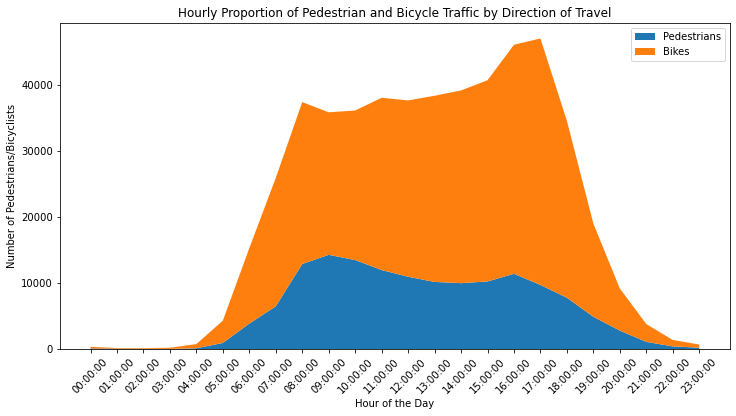

In [103]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate total number of pedestrians and bicyclists for each direction of travel
df['total_pedestrians'] = df['northbound pedestrians'] + df['southbound pedestrians']
df['total_bikes'] = df['northbound bikes'] + df['southbound bikes']
df['total_traffic'] = df['total_pedestrians'] + df['total_bikes']

# Create stacked area plot
ax.stackplot(df['hour of the day'], df['total_pedestrians'], df['total_bikes'], labels=['Pedestrians', 'Bikes'])

# Customize plot
ax.set_title('Hourly Proportion of Pedestrian and Bicycle Traffic by Direction of Travel')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Pedestrians/Bicyclists')
ax.legend()
plt.xticks(rotation=45)

# Display plot
plt.show()

Scatter plot to explore the relationship between pedestrian and bicycle traffic:

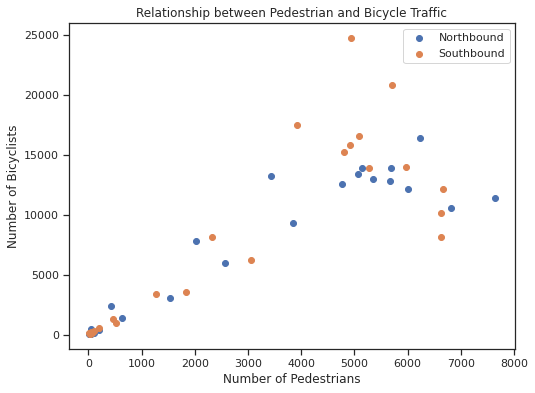

In [138]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Create scatter plot
ax.scatter(df['northbound pedestrians'], df['northbound bikes'], label='Northbound')
ax.scatter(df['southbound pedestrians'], df['southbound bikes'], label='Southbound')

# Customize plot
ax.set_title('Relationship between Pedestrian and Bicycle Traffic')
ax.set_xlabel('Number of Pedestrians')
ax.set_ylabel('Number of Bicyclists')
ax.legend()

# Display plot
plt.show()


#### Prompt: Create several fancy plots that are different types of visualizations and display them together

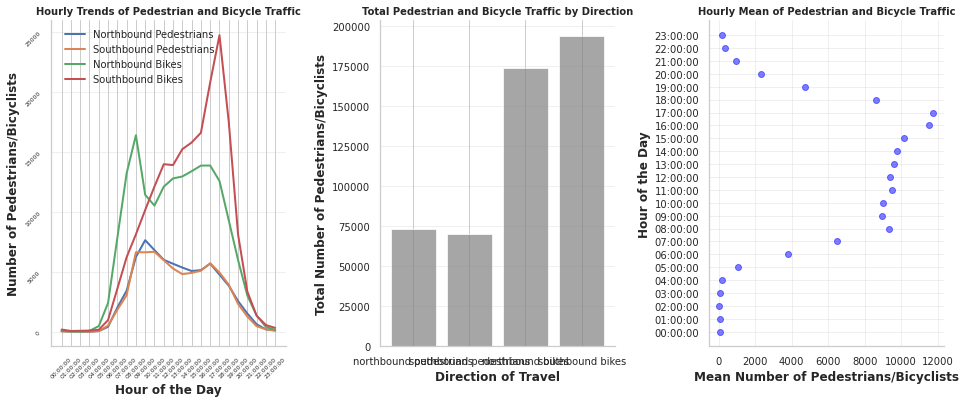

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('bg_traffic_bike_ped_2019.csv')

# Set default seaborn style
sns.set_style('whitegrid')

# Create figure and axes objects
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Plot data on first axis (line plot)
axs[0].plot(df['hour of the day'], df['northbound pedestrians'], label='Northbound Pedestrians', linewidth=2)
axs[0].plot(df['hour of the day'], df['southbound pedestrians'], label='Southbound Pedestrians', linewidth=2)
axs[0].plot(df['hour of the day'], df['northbound bikes'], label='Northbound Bikes', linewidth=2)
axs[0].plot(df['hour of the day'], df['southbound bikes'], label='Southbound Bikes', linewidth=2)
axs[0].set_title('Hourly Trends of Pedestrian and Bicycle Traffic', fontsize=10, fontweight='bold')
axs[0].set_xlabel('Hour of the Day', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Number of Pedestrians/Bicyclists', fontsize=12, fontweight='bold')
axs[0].legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.02, 1.0), frameon=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(axis='y', alpha=0.3)
axs[0].tick_params(labelsize=6, rotation=45)

# Plot data on second axis (bar plot)
hourly_totals = df[['northbound pedestrians', 'southbound pedestrians', 'northbound bikes', 'southbound bikes']].sum()
axs[1].bar(hourly_totals.index, hourly_totals.values, color='gray', alpha=0.7)
axs[1].set_title('Total Pedestrian and Bicycle Traffic by Direction', fontsize=10, fontweight='bold')
axs[1].set_xlabel('Direction of Travel', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Total Number of Pedestrians/Bicyclists', fontsize=12, fontweight='bold')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(axis='y', alpha=0.3)
axs[1].tick_params(labelsize=10)

# Plot data on third axis (scatter plot)
hourly_means = df[['northbound pedestrians', 'southbound pedestrians', 'northbound bikes', 'southbound bikes']].mean(axis=1)
axs[2].scatter(hourly_means, df['hour of the day'], color='blue', alpha=0.5)
axs[2].set_title('Hourly Mean of Pedestrian and Bicycle Traffic', fontsize=10, fontweight='bold')
axs[2].set_xlabel('Mean Number of Pedestrians/Bicyclists', fontsize=12, fontweight='bold')
axs[2].set_ylabel('Hour of the Day', fontsize=12, fontweight='bold')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].grid(axis='both', alpha=0.3)
axs[2].tick_params(labelsize=10)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display plot
plt.show()



## Question 5 (Grand challenge!): What day of the week is busiest on the Burke Gilman?

If we really want to understand whether people use the Burke Gilman for commuting, rather than just for recreation, we probably need to know what days of the week are busiest. 

We can answer this question using the same basic approach we used to answer the previous questions, but we will need a little bit of help. Since days of the week occur on different calendar days every year, we need a way to find out, for any given date in 2019, what day of the week that date fell on.

Python has a couple of tools that can help us with this:
- ``parse`` is a function from the ``dateutil`` library that can turn a date that is formatted as a string into a "datetime object", which is a format that Python understands as a real date, not just a series of characters.
- ``weekday`` is a function from the ``datetime`` library that can tell you, for any valid datetime object, what day of the week that date fell on.

In [39]:
from datetime import datetime #yes, I know this seems redundant
from dateutil import parser

Let's try out formatting one of our strings as a datetime object.

In [40]:
#here's a random date from our dataset, in its native string format
print(raw_data[234]['date'])

2019-01-10T19:00:00.000


In [41]:
#now let's use the parse function to turn that into datetime format, which Python can work with
parser.parse(raw_data[234]['date'])

datetime.datetime(2019, 1, 10, 19, 0)

That worked! We can save this datetime object in its own variable. That will let us do things with it (like find out what day of the week January 10th, 2019 was).

In [42]:
my_date = parser.parse(raw_data[234]['date'])
print(my_date)
print(type(my_date))

2019-01-10 19:00:00
<class 'datetime.datetime'>


Now that we know how to parse strings into datetime objects, we can use the ``datetime.weekday()`` function to find out what day of the week it was. This function will return a value between 0 (Monday) and 6 (Sunday) for any valid date you give it.

In [43]:
my_date.weekday() #starts at 0!

3

Looks like January 10th was a Thursday (you can check your calendar to confirm this).

### Answering Question 5
Now that you know how to find out the day of the week for any date in our ``raw_data`` dataset, you should be able to find out which weekday or weekend day sees the most traffic on the Burke Gilman. You'll be able to use loops, "if" statements, and dictionaries to calculate the totals for each day. 

Before you start, think for a minute: what do you think the answer will be, based on your own experience or your prior knowledge? Do you think the Burke Gilman is used more on weekdays or weekends? Why? Are some weekdays busier than others? Why?


# Congratulations! 

You have now mastered manipulating timeseries data in Python. There are plenty of other techniques, tools, and time-saving tricks that you can learn to build on these skills, but many data scientists who use Python every day do this kind of work using the same basic approach you just learned.

## Challenges: going further

Here are some additional questions that you now have the tools you need to answer, based on what you've done today:

- what day of the week is busiest for bikes? Is it the same as the busiest day for pedestrians?
- what month of the year is busiest? (aka do Seattlites really like to ride in the rain?)
- has the Burke Gilman gotten busier over time? (the dataset we have goes back to 2014!)
- do fewer people commute on the Burke Gilman when it's cold out? (hint: try combining this dataset with the [dataset on road temperature over time](https://data.seattle.gov/Public-Safety/Road-Weather-Information-Stations/egc4-d24i/data)
- do more people commute into Seattle in the mornings by bike on the Burke Gilman, or on the [the Mountain to Sound Trail](https://data.seattle.gov/Transportation/MTS-Trail-west-of-I-90-Bridge-Bicycle-and-Pedestri/u38e-ybnc)?

## Other data.seattle.gov datasets that you can do timeseries with...
- Fremont bridge bicycle counter: https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
- Spokane Street bridge bicycle counter: https://data.seattle.gov/Transportation/Spokane-St-Bridge-Bicycle-Counter/upms-nr8w
- Mountain to Sound trail bicycle + pedestrian counter: https://data.seattle.gov/Transportation/MTS-Trail-west-of-I-90-Bridge-Bicycle-and-Pedestri/u38e-ybnc


## More complex datasets

- https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8
- https://data.seattle.gov/Permitting/Building-Permits/76t5-zqzr